In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.colors

import torch
from collections import OrderedDict, defaultdict

In [2]:
def get_tensor_sparsity(t):
    nnz = t.count_nonzero()
    nparam = t.numel()
    sparsity = 1-nnz/nparam
    return sparsity, nnz, nparam

In [3]:
def plot_sparsity(tensor, binarized=True, ax=None, grid=None, interval=None, label=None, detail=False, offaxis=False):
    # Color for False and True
    cmap = matplotlib.colors.ListedColormap(['deeppink', 'black'])

    sparsity, nnz, nparam = get_tensor_sparsity(tensor)
    if detail is True:
        sparsity_str = "sparsity: {:.0f}% ({:,}/{:,})".format(sparsity*100, nnz, nparam)
    else:
        sparsity_str = "sparsity: {:.0f}%".format(sparsity*100)
    if ax is None:
        plt.figure(figsize=(10, 18))
        if binarized is True:
            plt.imshow((tensor != 0).detach().cpu(), cmap=cmap)
        else:
            plt.imshow(tensor.detach().cpu(), cmap=cmap)
        if grid=='x':
            plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(interval))
            plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
            plt.grid(axis = 'x', which='major', color='#CCCCCC', linestyle='--')
        elif grid=='y':
            plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(interval))
            plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
            plt.grid(axis = 'y', which='major', color='#CCCCCC', linestyle='--')
        if label is not None:
            plt.title('\n'.join([label, sparsity_str]))
        if offaxis is True:
            plt.axis('off')
    else:
        if binarized is True:
            ax.imshow((tensor != 0).detach().cpu(), cmap=cmap)
        else:
            ax.imshow(tensor.detach().cpu(), cmap=cmap)
        if grid=='x':
            ax.xaxis.set_major_locator(ticker.MultipleLocator(interval))
            ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
            ax.grid(axis = 'x', which='major', color='#CCCCCC', linestyle='--')
        elif grid=='y':
            ax.yaxis.set_major_locator(ticker.MultipleLocator(interval))
            ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
            ax.grid(axis = 'y', which='major', color='#CCCCCC', linestyle='--')
        if label is not None:
            ax.set_title('\n'.join([label, sparsity_str]))
        if offaxis is True:
            ax.axis('off')

# ax.grid(which='minor', color='#CCCCCC', linestyle=':')

In [4]:
def process_ckpt_to_tensor_dict(ckpt_path, ckpt_type=None):
    sd=torch.load(ckpt_path)
    if ckpt_type == 'nncf_sparsified':
        # nncf_sparsified_checkpoint
        target_keys = []
        for k, v in sd.items():
            if '_binary_mask' in k:
                sparsity, nparam, nnz = get_tensor_sparsity(v)
                # print("{:.3f} | {}".format(sparsity, k))
                target_keys.append(k)

        # Routine to extract nncf mask in transformer tblock
        # tblock['bert.encoder.layer.0'].keys()
        # 'query', 'key', 'value', 'attention.output', 'ffnn.intermediate', 'ffnn.output'

        tblock=OrderedDict()

        for n, t in sd.items():
            if 'embeddings' in n or 'LayerNorm' in n:
                continue
            # elif 'encoder' in n and 'weight' in n:
            elif 'encoder' in n and '_binary_mask' in n:
                label_token = n.replace('nncf_module.',"").split(".")
                key='.'.join(label_token[:4])

                if key not in tblock:
                    tblock[key]=OrderedDict()

                if 'attention' in n:
                    if 'output' in n:
                        t_label = '.'.join(label_token[4:6])
                    else:
                        t_label = label_token[6]
                    tblock[key][t_label] = t
                else:
                    t_label = 'ffnn.{}'.format(label_token[4])
                    tblock[key][t_label] = t
    else:
        # standard ckpt
        target_keys = []
        for k, v in sd.items():
            if 'weight' in k and 'bert.encoder.layer.' in k and 'LayerNorm' not in k:
                target_keys.append(k)

        # Routine to extract nncf mask in transformer tblock
        # tblock['bert.encoder.layer.0'].keys()
        # 'query', 'key', 'value', 'attention.output', 'ffnn.intermediate', 'ffnn.output'

        tblock=OrderedDict()

        for n, t in sd.items():
            if n in target_keys:
                label_token = n.split('.')
                key='.'.join(label_token[:4])

                if key not in tblock:
                    tblock[key]=OrderedDict()

                if 'attention' in n:
                    if 'output' in n:
                        t_label = '.'.join(label_token[4:6])
                    else:
                        t_label = label_token[6]
                    tblock[key][t_label] = t
                else:
                    t_label = 'ffnn.{}'.format(label_token[4])
                    tblock[key][t_label] = t
    return tblock, target_keys

In [5]:
ckpt_path = '/data1/vchua/tld-poc/repo/bert-base-uncased-squad/pytorch_model.bin'
tblock, _ = process_ckpt_to_tensor_dict(ckpt_path)

In [22]:
# testing
# plot_sparsity(sd[target_keys[0]], grid='y', interval=64, label=target_keys[0])
# plot_sparsity(sd[target_keys[4]], label=target_keys[4])

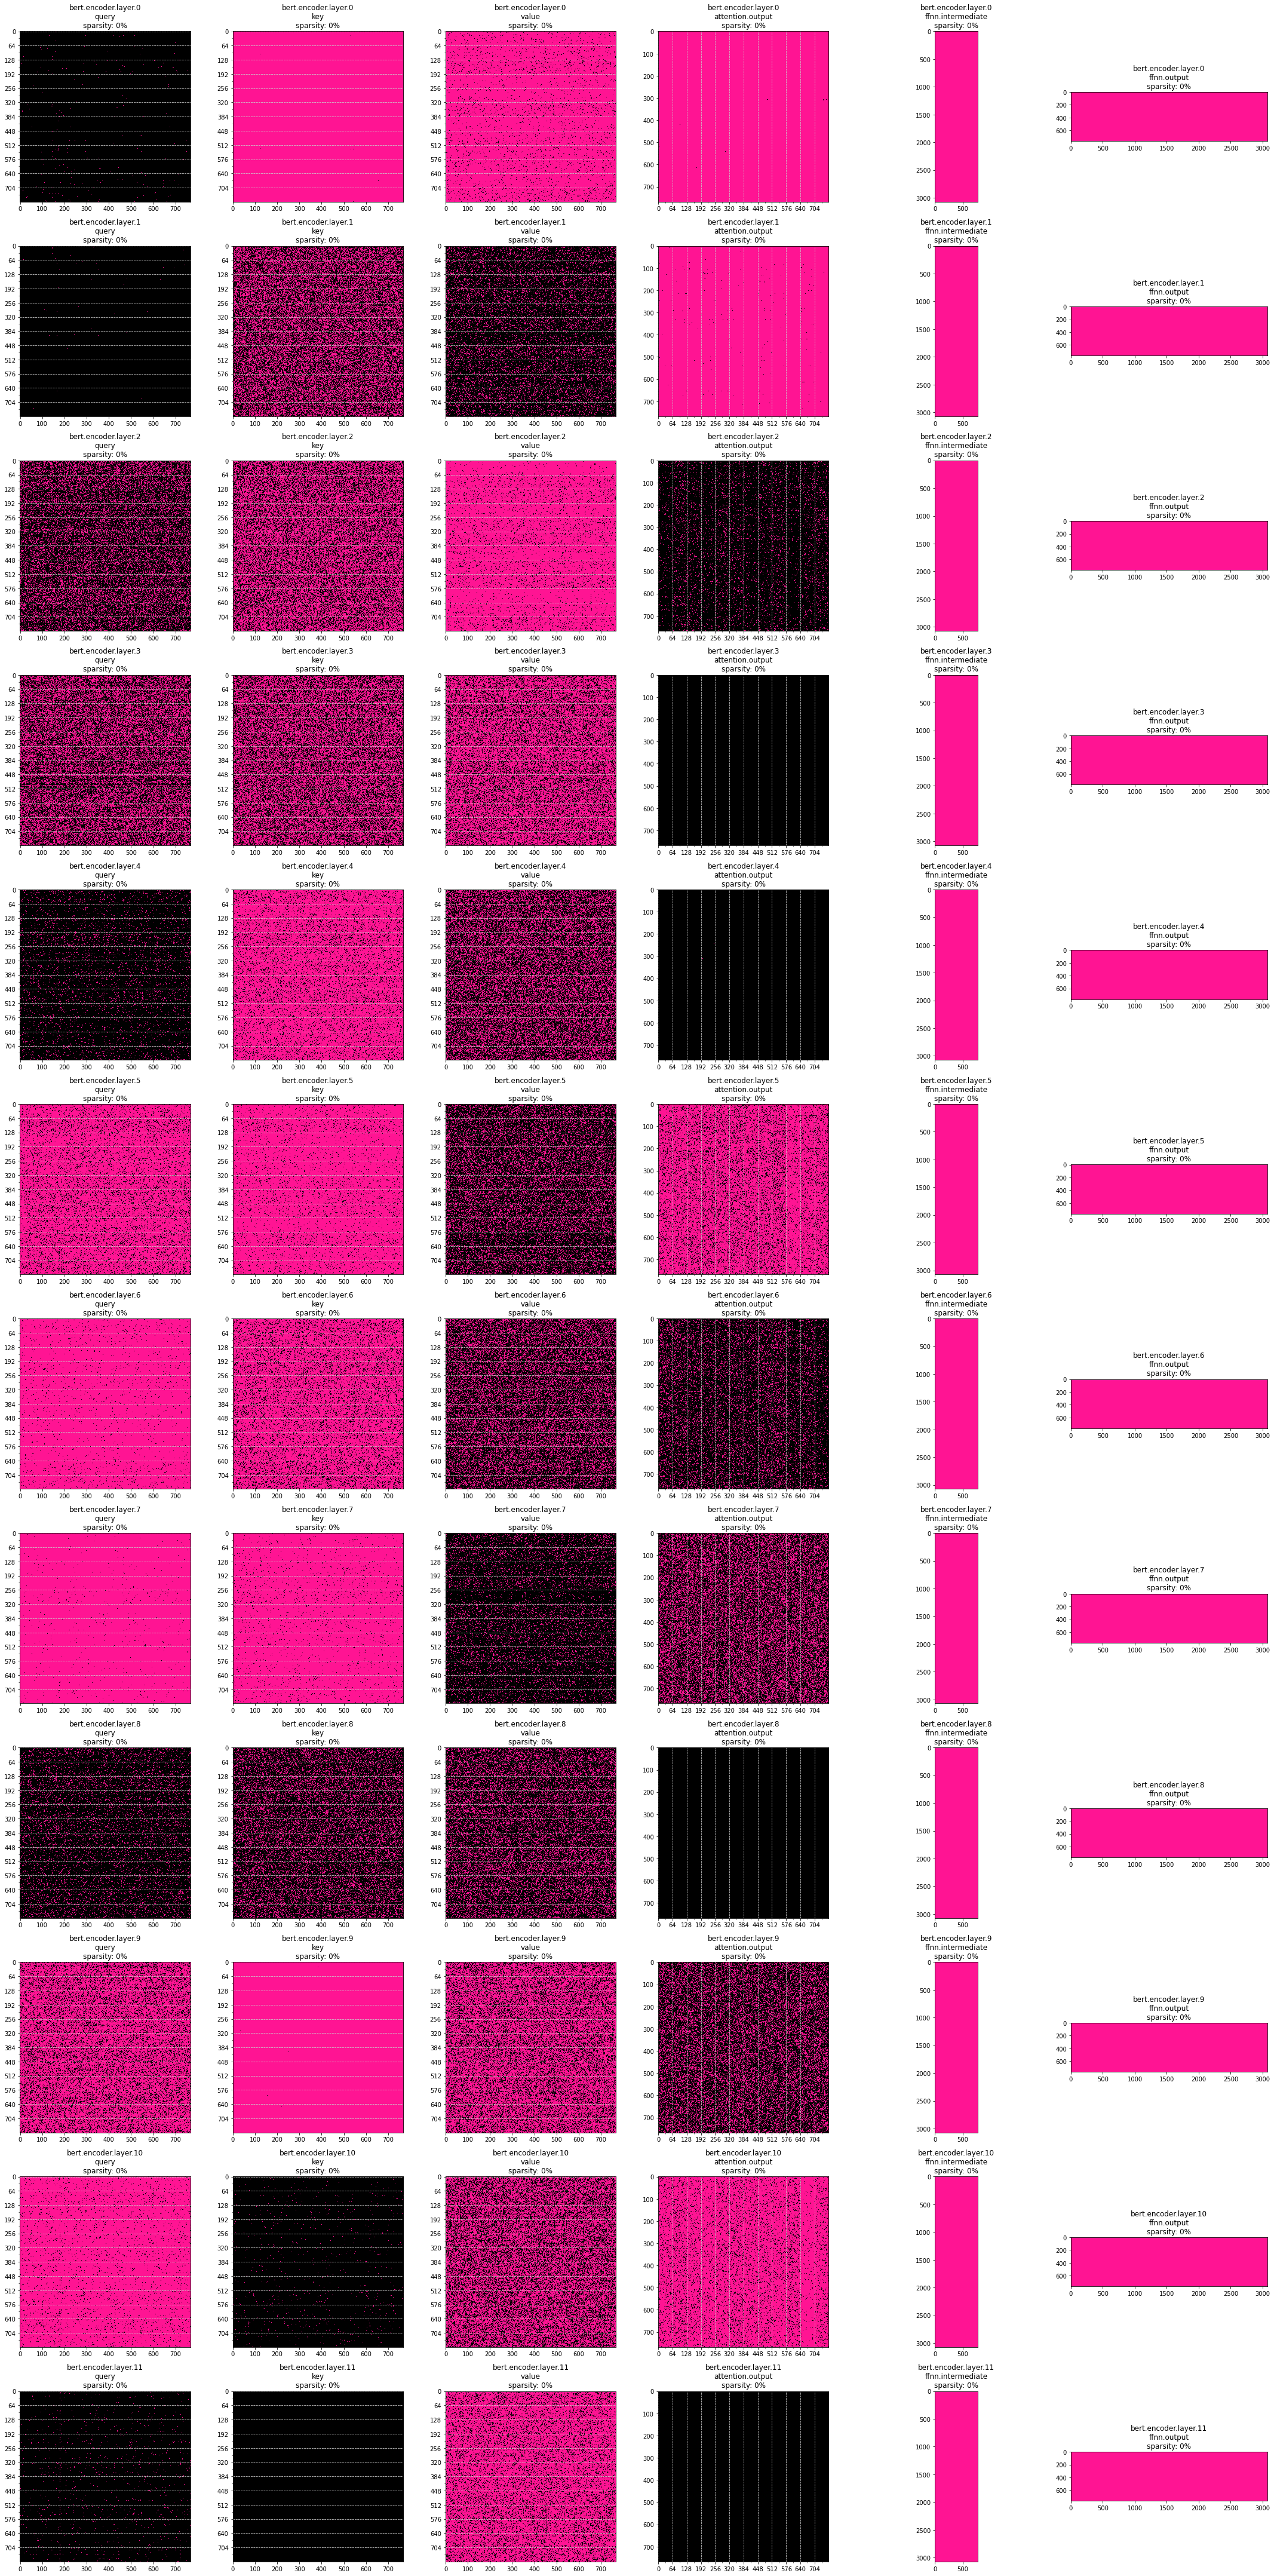

In [6]:
fig, ax = plt.subplots(nrows=len(tblock), ncols=len(list(tblock.values())[0]), figsize=(30,60))

for r, (tname, all_mask) in enumerate(tblock.items()):
    for c, (mask_key, mask) in enumerate(all_mask.items()):
        label = '\n'.join([tname, mask_key])
        
        if mask_key in ['query', 'key', 'value']:
            plot_sparsity(mask, ax=ax[r][c], binarized=False, grid='y', interval=64, label=label)
            # plot_sparsity(mask, ax=ax[r][c], label=label)
        elif mask_key in ['attention.output']:
            plot_sparsity(mask, ax=ax[r][c], binarized=False, grid='x', interval=64, label=label)
            # plot_sparsity(mask, ax=ax[r][c], label=label)
        else:
            plot_sparsity(mask, ax=ax[r][c], label=label)
plt.tight_layout()

In [7]:
# fig.savefig("bert-base-uncased-squad.png")

In [8]:
ckpt_path = '/data1/vchua/tld-poc/repo/bert-base-squadv1-block-pruning-hybrid-filled-lt/pytorch_model.bin'
tblock, _ = process_ckpt_to_tensor_dict(ckpt_path)

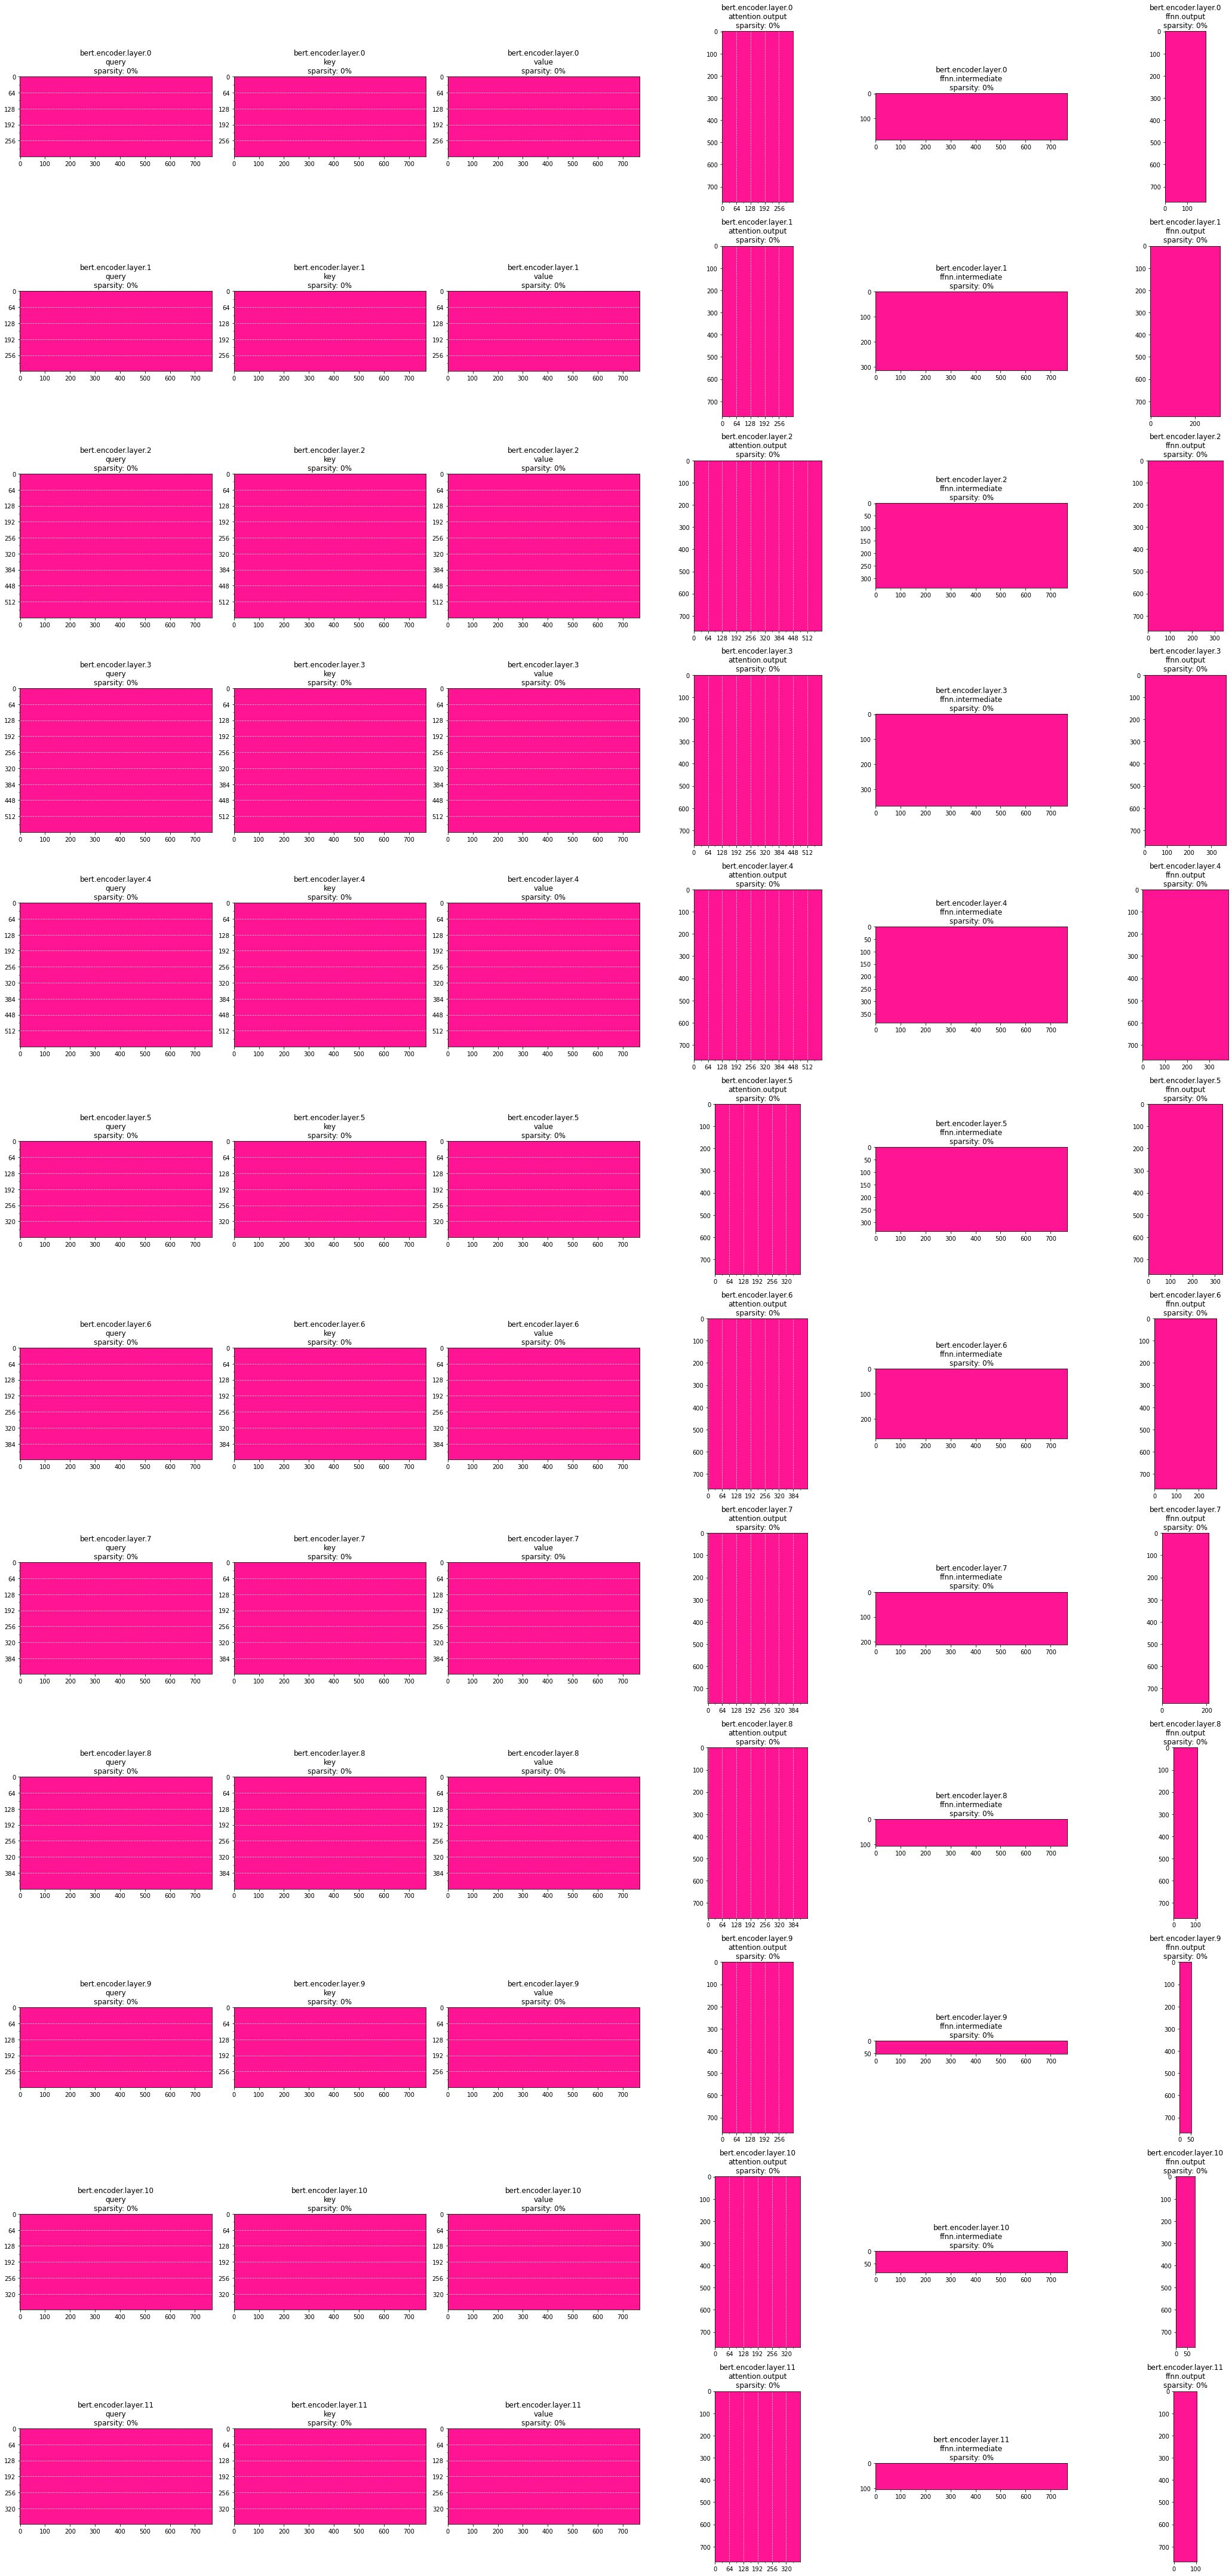

In [9]:
fig, ax = plt.subplots(nrows=len(tblock), ncols=len(list(tblock.values())[0]), figsize=(30,60))

for r, (tname, all_mask) in enumerate(tblock.items()):
    for c, (mask_key, mask) in enumerate(all_mask.items()):
        label = '\n'.join([tname, mask_key])
        
        if mask_key in ['query', 'key', 'value']:
            plot_sparsity(mask, ax=ax[r][c], grid='y', interval=64, label=label)
            # plot_sparsity(mask, ax=ax[r][c], label=label)
        elif mask_key in ['attention.output']:
            plot_sparsity(mask, ax=ax[r][c], grid='x', interval=64, label=label)
            # plot_sparsity(mask, ax=ax[r][c], label=label)
        else:
            plot_sparsity(mask, ax=ax[r][c], label=label)
plt.tight_layout()

In [37]:
# fig.savefig("bert-base-squadv1-block-pruning-hybrid-filled-lt.png")

In [10]:
ckpt_path = '/data1/vchua/tld-poc/repo/bert-base-squadv1-block-pruning-hybrid-filled-lt-nncf-60.0sparse-qat-lt/checkpoint-22000/pytorch_model.bin'
tblock, _ = process_ckpt_to_tensor_dict(ckpt_path, ckpt_type='nncf_sparsified')

In [11]:
# fig.savefig("bert-base-squadv1-block-pruning-hybrid-filled-lt-nncf-60.0sparse-qat-lt.png")

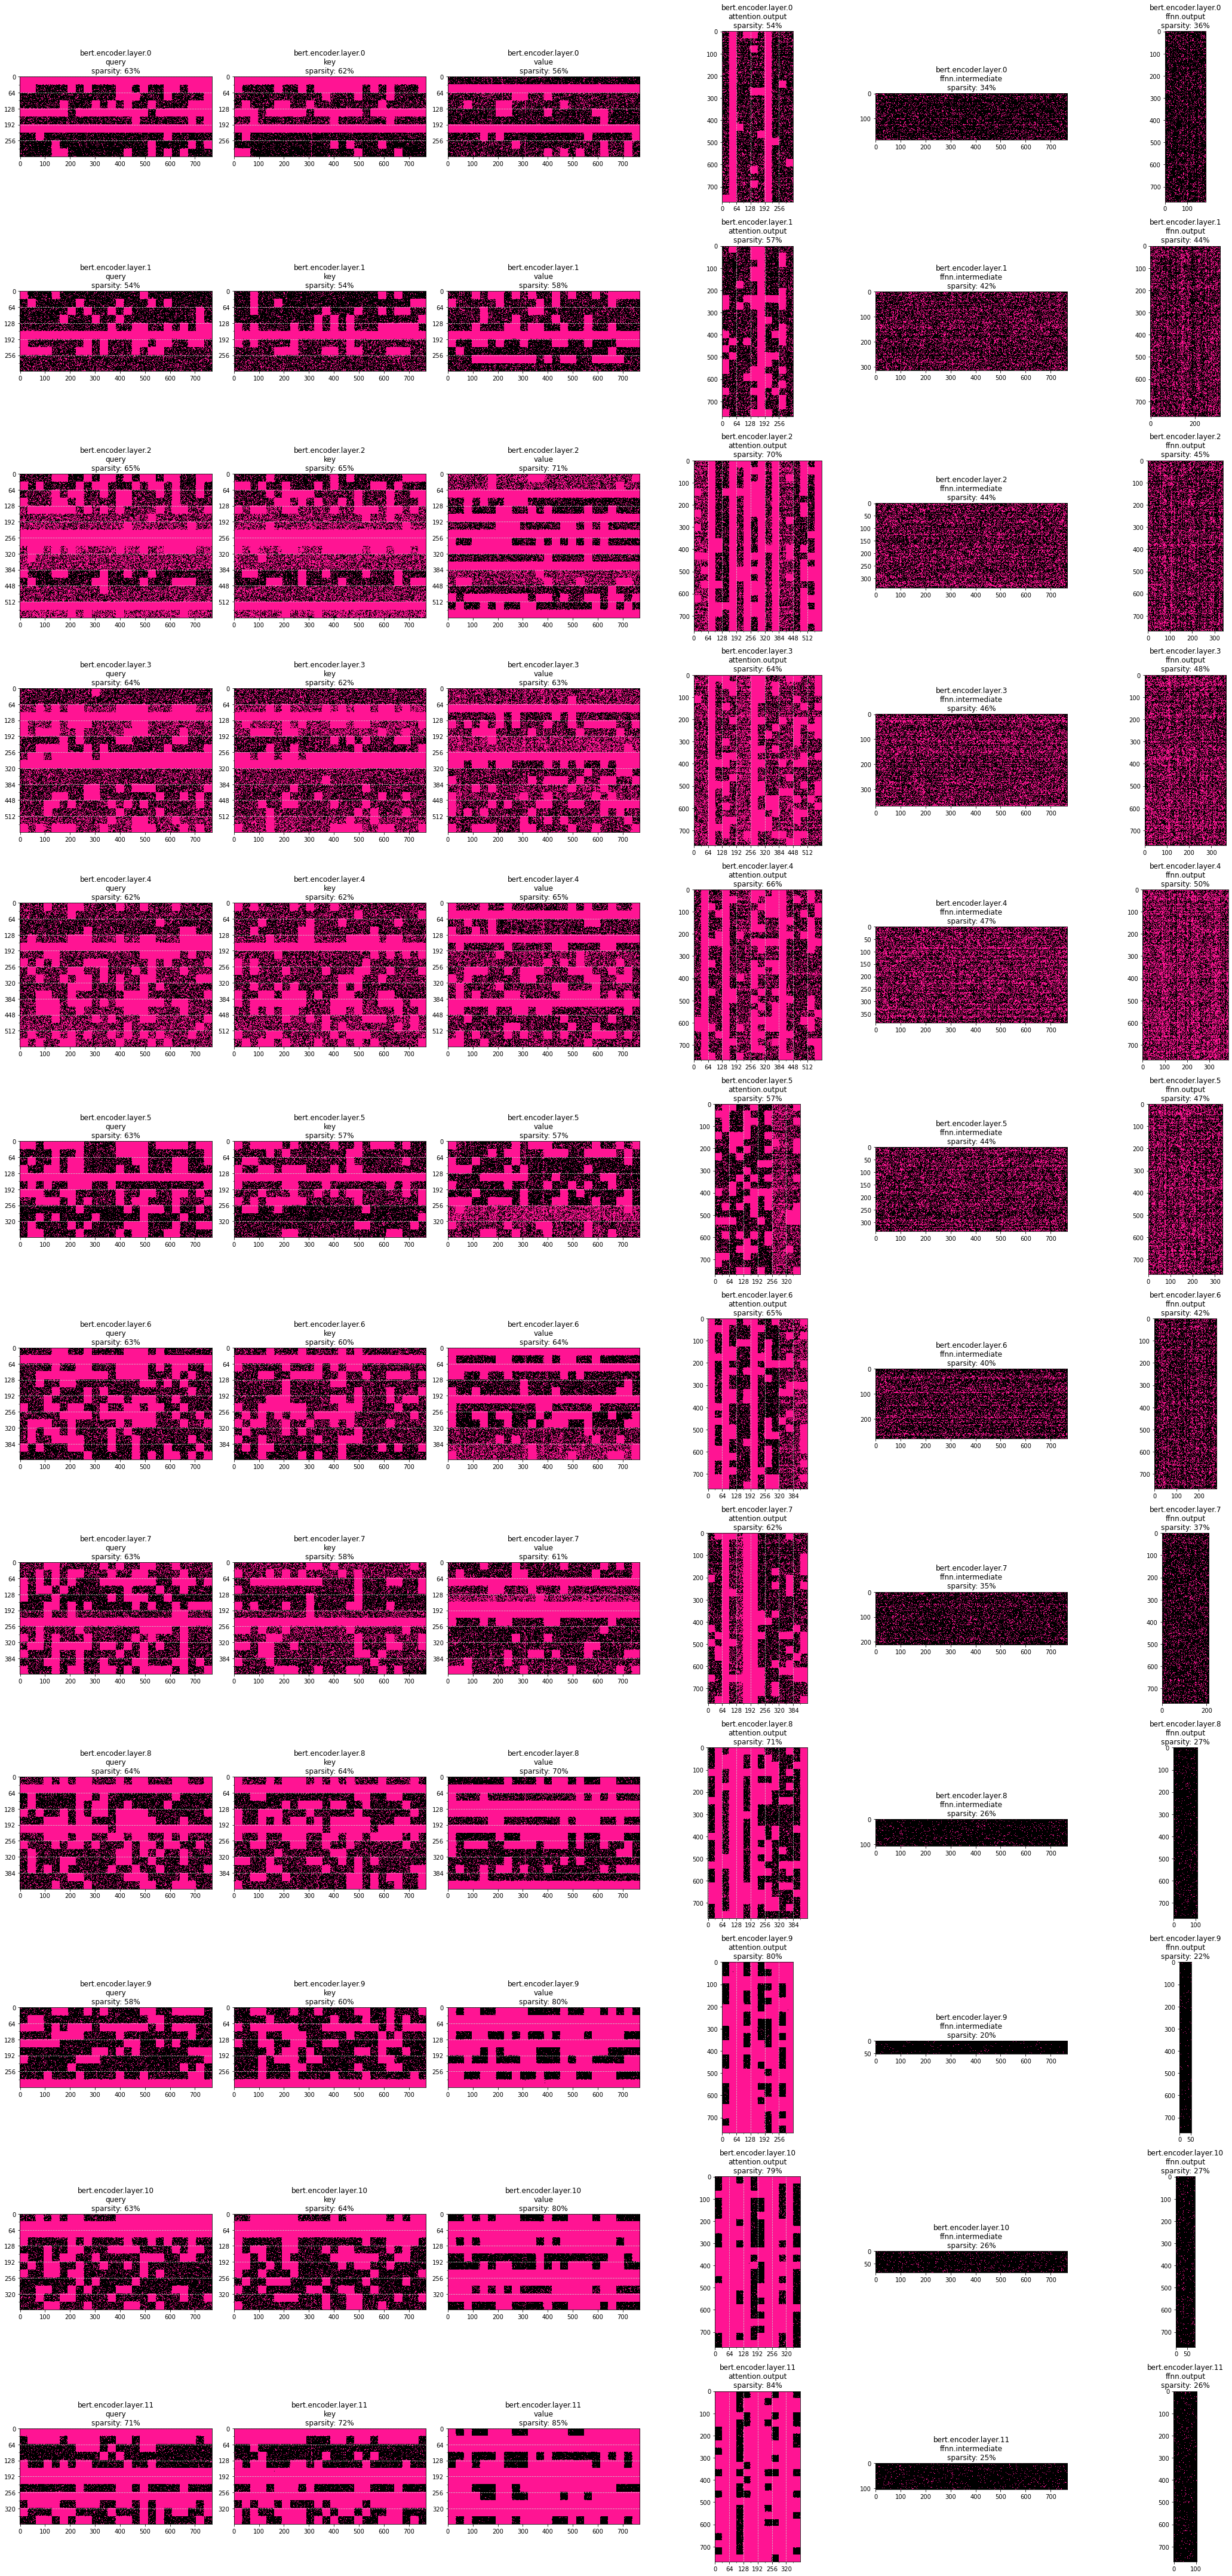

In [12]:
fig, ax = plt.subplots(nrows=len(tblock), ncols=len(list(tblock.values())[0]), figsize=(30,60))

for r, (tname, all_mask) in enumerate(tblock.items()):
    for c, (mask_key, mask) in enumerate(all_mask.items()):
        label = '\n'.join([tname, mask_key])
        
        if mask_key in ['query', 'key', 'value']:
            plot_sparsity(mask, ax=ax[r][c], grid='y', interval=64, label=label)
            # plot_sparsity(mask, ax=ax[r][c], label=label)
        elif mask_key in ['attention.output']:
            plot_sparsity(mask, ax=ax[r][c], grid='x', interval=64, label=label)
            # plot_sparsity(mask, ax=ax[r][c], label=label)
        else:
            plot_sparsity(mask, ax=ax[r][c], label=label)
plt.tight_layout()